# Sampling from mixture distributions

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

dist1 = stats.beta(10, 5)
dist2 = stats.beta(2, 6)
w = np.array([.3, .7])

We start plotting the PDFs of each component (note that the pdf of each component are weighted and therefore not normalized at 1 but at the weight, it is the contribution they make to the mixture, not the pdf of the independent component)

Text(0.5, 0.98, 'PDFs of mixture and components')

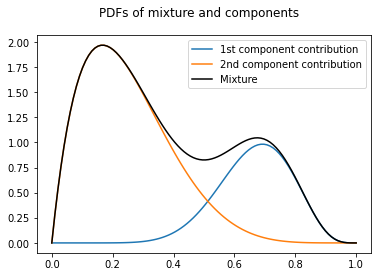

In [2]:
x = np.linspace(0, 1, 100)
plt.plot(x, w[0] * dist1.pdf(x), label="1st component contribution")
plt.plot(x, w[1] *dist2.pdf(x), label="2nd component contribution")
plt.plot(x, w[0] * dist1.pdf(x) + w[1] * dist2.pdf(x), "k", label="Mixture")
plt.legend()
plt.suptitle("PDFs of mixture and components")

We now generate samples from the mixture. Here are some naive things we could try that do not work:

Sum the samples like we did with the pdfs:

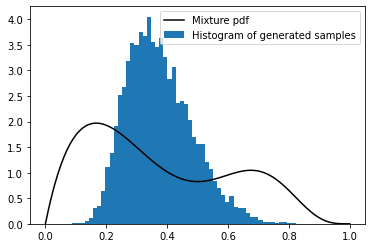

In [3]:
samples1 = dist1.rvs(10000)
samples2 = dist2.rvs(10000)

plt.plot(x, w[0] * dist1.pdf(x) + w[1] * dist2.pdf(x), "k", label="Mixture pdf")
plt.hist(w[0]*samples1+w[1]*samples2, bins="auto", density=True, label="Histogram of generated samples")
plt.legend()

Generate half the samples from each distribution so we get the total at the desired 10000 (very close to working)

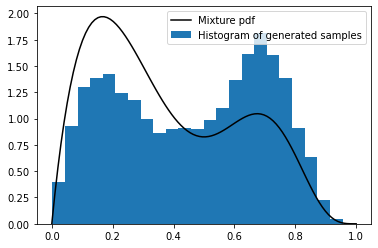

In [4]:
samples1 = dist1.rvs(5000)
samples2 = dist2.rvs(5000)
samples = np.hstack((samples1, samples2))

plt.plot(x, w[0] * dist1.pdf(x) + w[1] * dist2.pdf(x), "k", label="Mixture pdf")
plt.hist(samples, bins="auto", density=True, label="Histogram of generated samples")
plt.legend()

The method above is already valid, but we are not using the right weights:

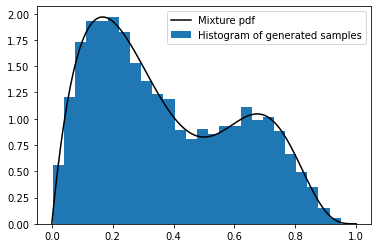

In [5]:
samples1 = dist1.rvs(int(10000*w[0]))
samples2 = dist2.rvs(int(10000*w[1]))
samples = np.hstack((samples1, samples2))

plt.plot(x, w[0] * dist1.pdf(x) + w[1] * dist2.pdf(x), "k", label="Mixture pdf")
plt.hist(samples, bins="auto", density=True, label="Histogram of generated samples")
plt.legend()

This is still not ideal though, if the 10000 samples are posterior samples for example, then the weights and parameters of the beta would be different at each iteration. One alternative is generating samples for all components, then sampling an index with probability equal to the weights and keep that sample:

(2, 10000)
(10000,)
(10000,)


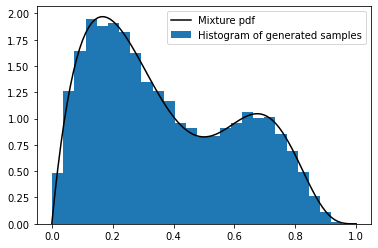

In [6]:
samples1 = dist1.rvs(10000)
samples2 = dist2.rvs(10000)
samples_combined = np.vstack((samples1, samples2))
print(samples_combined.shape)
rng = np.random.default_rng()
index = rng.choice([0, 1], p=w, size=10000)
print(index.shape)
# at each sample keep the draw from the component indicated in index
samples = samples_combined[index, np.arange(10000)] 
print(samples.shape)

plt.plot(x, w[0] * dist1.pdf(x) + w[1] * dist2.pdf(x), "k", label="Mixture pdf")
plt.hist(samples, bins="auto", density=True, label="Histogram of generated samples")
plt.legend()

a posterior like situation

In [7]:
a = rng.exponential(size=(4, 100, 3))
b = rng.exponential(size=(4, 100, 3))
theta = rng.dirichlet([.25, .35, .4], size=(4, 100))

In [8]:
import arviz as az
import xarray as xr
from xarray_einstats.stats import XrContinuousRV, XrDiscreteRV

idata = az.from_dict(
    dict(a=a, b=b, theta=theta), 
    dims={"a": ["component"], "b": ["component"], "theta": ["component"]}
)
idata

Inference data with groups:
	> posterior

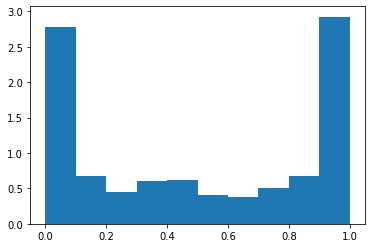

In [9]:
post = az.extract_dataset(idata)
samples_combined = XrContinuousRV(stats.beta, post["a"], post["b"]).rvs()
index = [rng.choice(np.arange(3), p=post["theta"].isel(sample=i)) for i in range(400)]

samples = samples_combined.sel(component=xr.DataArray(index, dims=["sample"]))
plt.hist(samples, bins="auto", density=True);